# **Fine-Tuning модели BERT для Multi-Label классификации отзывов**

## Описание проекта

### Заказчик  
Samokat.Tech

### Исполнитель  
Мельник Даниил Владимирович

---

### **Описание**

#### **Цель**  

Разработать модель для классификации отзывов пользователей с возможностью присвоения нескольких меток (Multi-Label Classification). Модель должна учитывать пересечение тематик в тексте и предсказывать все затронутые классы.

**Основная метрика оценки** — **Accuracy**.  

Accuracy в задаче множественной классификации рассчитывается как доля полных совпадений между списком предсказанных и целевых классов:  

$$Accuracy = \frac{\text{Количество полных совпадений списков классов}}{\text{Общее количество экземпляров}}$$

#### **Задачи**  
1. Подготовить данные для обучения модели, включая обработку текстов и меток.  
2. Настроить процесс обучения модели на базе BERT с использованием методов Fine-Tuning.  
3. Реализовать метрику Accuracy для оценки точности модели в задаче множественной классификации.  
4. Обучить модель
5. Оценить качество модели на тестовой выборке и подготовить файл предсказаний.  

---

### **Данные**

#### **Описание набора данных**  
Датасет состоит из текстов отзывов, тегов и соответствующих им меток классов.

#### **Файлы**
1. **train.csv**  
   Поля:  
   - `ID`: идентификатор экземпляра.  
   - `text`: текст отзыва.  
   - `tags`: метки (предварительные теги из анкеты).  
   - `trend_id_res0, trend_id_res1, ..., trend_id_res49`: метки по каждому из 50 классов (0 или 1).  

2. **test.csv**  
   Поля:  
   - `ID`: идентификатор экземпляра.  
   - `text`: текст отзыва.  
   - `tags`: метки (предварительные теги из анкеты).  

3. **trends_description.csv**  
   Поля:  
   - `trend_id`: идентификатор класса.  
   - `trend`: краткое название класса.  
   - `explanation`: подробное описание класса.

---

### **Технологический стек**  
- Python, NumPy, pandas  
- Transformers (Hugging Face)  
- PyTorch
- scikit-learn  
- Matplotlib, Seaborn  

---

### Установка библиотек

In [1]:
!pip install iterative-stratification -q

### Импорт библиотек

In [2]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wandb
from google.colab import drive, userdata
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

### Пользовательские функции

In [3]:
def correct_spelling_errors(df, column_name):
    """
    Исправляет орфографические ошибки в текстовом столбце датафрейма.

    Параметры:
        df (pd.DataFrame): Датафрейм, содержащий столбец с текстом.
        column_name (str): Название столбца, в котором нужно исправить ошибки.

    Возвращает:
        pd.DataFrame: Датафрейм с исправленными текстами в указанном столбце.
    """
    # Словарь исправлений
    corrections = {
        "соотвесвует": "соответствует",
        "акцентриет": "акцентирует",
        "жалутеся": "жалуется",
        "сроком годнос": "сроком годности",
        "коментариях": "комментариях",
        "упомианет": "упоминает",
        "конркетную": "конкретную",
        "недовезли": "не довезли",
        "йогрут": "йогурт",
        "повереждения": "повреждения",
        "кпоминания": "упоминания",
        "заменчания": "замечания",
        "деражть": "держать",
        "скидко": "скидкой",
        "каой-то": "какой-то",
        "поянтно": "понятно",
        "скикдка": "скидка",
        "жалуктся": "жалуется",
        "качестова": "качества",
        "товаро": "товара",
        "комменатрии": "комментарии",
        "банеру": "баннеру",
        "поддрежки": "поддержки",
        "жалуетя": "жалуется",
        "комментраии": "комментарии",
        "атвоматически": "автоматически"
    }

    # Применяем исправления
    df[column_name] = df[column_name].replace(corrections, regex=True)
    return df

In [4]:
def analyze_class_distribution(df, column_name):
    """
    Анализ распределения классов по указанным столбцам и построение графика.

    Параметры:
        df (pd.DataFrame): Датафрейм с данными.
        column_name (str): Префикс столбцов, соответствующий классу (например, 'trend_id_res').

    Возвращает:
        None
    """
    # Получаем список столбцов, связанных с column_name
    trend_columns = [col for col in df.columns if col.startswith(column_name)]

    # Суммируем значения по каждому столбцу
    class_distribution = df[trend_columns].sum()

    # Вычисляем долю объектов каждого класса
    class_proportions = class_distribution / class_distribution.sum()

    # Вывод долей объектов каждого класса
    #print(f"Распределение классов {column_name} (доля объектов):")
    #print(class_proportions)

    # Построение графика распределения классов
    plt.figure(figsize=(10, 6))
    class_proportions.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Распределение классов в датафрейме: {df.name} (доля объектов)", fontsize=14)
    plt.xlabel("Классы", fontsize=12)
    plt.ylabel("Доля объектов", fontsize=12)
    plt.xticks(rotation=90, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [5]:
def format_texts(df):
    """
    Форматирует строки из DataFrame в заданном формате.

    Args:
        df (pd.DataFrame): DataFrame с колонками "assessment", "tags", "text".

    Returns:
        list: Список строк, отформатированных как
              "assessment: ..., tags: ..., text: ...".
    """
    return [
        f"assessment: {assessment}, tags: {tags}, text: {text}"
        for assessment, tags, text in zip(df["assessment"], df["tags"], df["text"])
    ]

In [6]:
def compute_metrics(p):
    preds = torch.sigmoid(torch.tensor(p.predictions)).numpy()  # Применяем сигмоид
    labels = p.label_ids
    # Применяем порог 0.5 для бинарных меток
    preds = (preds > 0.5).astype(int)

    # Вычисляем точность с полным совпадением вектора классов для каждого экземпляра
    accuracy = np.mean([np.array_equal(labels[i], preds[i]) for i in range(labels.shape[0])])

    # Взвешенная F1-метрика, которая учитывает дисбаланс классов
    f1 = f1_score(labels, preds, average='weighted', zero_division=1)

    return {'accuracy': accuracy, 'f1_weighted': f1}

### Глобальные переменные

In [9]:
RANDOM_STATE = 42
WANDB_TOKEN = userdata.get('WANDB_TOKEN')
PATH = '/content/drive/MyDrive/Samokat/'
MODEL_NAME_0 = "roberta-base"
MODEL_NAME_1 = "microsoft/deberta-v3-base"
MODEL_NAME_2 = "albert-base-v2"
MODEL_NAME_3 = "distilbert-base-uncased"
MODEL_NAME_4 = "google-bert/bert-base-multilingual-cased"
MODEL_NAME_5 = "DeepPavlov/bert-base-bg-cs-pl-ru-cased"

In [10]:
MODEL_NAME = MODEL_NAME_5

Проверим доступность GPU

In [ ]:
# Проверяем доступность CUDA
if not torch.cuda.is_available():
    print("CUDA не доступна. Обучение будет выполняться на CPU.")
    DEVICE = 'cpu'
else:
    num_gpus = torch.cuda.device_count()
    if num_gpus == 1:
        print("CUDA доступна! Обучение будет выполняться на одном GPU.")
        DEVICE = "cuda"
    elif num_gpus > 1:
        print(f"CUDA доступна! Обучение будет выполняться на {num_gpus} GPU.")
        DEVICE = "cuda"
    else:
        print("Ошибка определения устройства.")
        DEVICE = 'cpu'

print(f"Используемое устройство: {DEVICE}")

CUDA доступна! Обучение будет выполняться на одном GPU.
Используемое устройство: cuda


## Загрузка данных

Подключим Google Drive

In [11]:
drive.mount('/content/drive')

Mounted at /content/drive


Считаем файлы в датафреймы

In [12]:
df_trends = pd.read_csv(PATH + "trends_description.csv")

In [13]:
df_reviews = pd.read_csv(PATH + "train.csv")

In [14]:
df_test = pd.read_csv(PATH + "test.csv")

Проверим наличие пропусков в датафреймах

In [15]:
df_trends.isna().sum()

,0
trend_id,0
trend,0
explanation,0


In [16]:
df_reviews.isna().sum()

,0
index,0
assessment,230
tags,11
text,0
trend_id_res0,0
trend_id_res1,0
trend_id_res2,0
trend_id_res3,0
trend_id_res4,0
trend_id_res5,0


In [17]:
df_test.isna().sum()

,0
index,0
assessment,466
tags,32
text,2


В датафреймах `df_reviews` и `df_test` наблюдаются пропуски в столбцах `assessment` и `tags`

## Просмотр и предобработка

### `df_trends`

Просмотрим содержимое датафреймов

In [18]:
# Просмотр данных
df_trends.head(50)

,trend_id,trend,explanation
0,0,Долгая доставка,- долго везёте\n- очень долго везёте\n- сюда о...
1,1,Доставка стала долгой,"- клиент делает акцент на то, что раньше мы до..."
2,2,Время доставки не соответствует заявленому,"- клиент акцентирует внимание, что SLA не соот..."
3,3,Регулярные опоздания,"- клиент акцентриет внимание, что мы часто/каж..."
4,4,Не отследить реальное время доставки,"- клиент говорит о том, что невозможно понять,..."
5,5,Курьер на карте,- если клиент упоминает отображение курьера на...
6,6,Нет доставки по адресу,"клиент жалутеся, что нет доставки по адресу"
7,7,Не предупреждаем об удалении товара,- не предупреждаем об удалении товара\n- не пр...
8,8,Высокая минимальная сумма заказа,клиент жалуется на размер минимальной суммы за...
9,9,Сумма заказа меняется во время набора корзины,- сумма заказа меняется во время набора корзин...


Обнаружены ошибки в `df_trends`, применим функцию для их исправления

In [19]:
df_trends = correct_spelling_errors(df_trends, "explanation")

Удалим служебные символы

In [20]:
# Удаляем символы новой строки, табуляции и лишние пробелы
df_trends['explanation'] = df_trends['explanation'].str.replace(r'[\n\t]', ' ', regex=True).str.strip()

Выведем исправленный `df_trends`

In [21]:
df_trends.head(10)

,trend_id,trend,explanation
0,0,Долгая доставка,- долго везёте - очень долго везёте - сюда отн...
1,1,Доставка стала долгой,"- клиент делает акцент на то, что раньше мы до..."
2,2,Время доставки не соответствует заявленому,"- клиент акцентирует внимание, что SLA не соот..."
3,3,Регулярные опоздания,"- клиент акцентирует внимание, что мы часто/ка..."
4,4,Не отследить реальное время доставки,"- клиент говорит о том, что невозможно понять,..."
5,5,Курьер на карте,- если клиент упоминает отображение курьера на...
6,6,Нет доставки по адресу,"клиент жалуется, что нет доставки по адресу"
7,7,Не предупреждаем об удалении товара,- не предупреждаем об удалении товара - не пре...
8,8,Высокая минимальная сумма заказа,клиент жалуется на размер минимальной суммы за...
9,9,Сумма заказа меняется во время набора корзины,- сумма заказа меняется во время набора корзин...


### `df_reviews`

Выведем датафрейм

In [22]:
df_reviews.head()

,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15237,5.0,"{ASSORTMENT,PRODUCTS_QUALITY,PROMOTIONS,CATALO...",Доставка просто 👍,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Проверка количества отзывов, для которых не выбран ни один из классов

In [23]:
# Создаем маску для отзывов, у которых не выбран ни один из классов
mask = (df_reviews.iloc[:, 4:] == 0).all(axis=1)

In [24]:
# Фильтруем отзывы, у которых не выбран ни один из классов
reviews_with_no_classes = df_reviews[mask]

In [25]:
# Количество таких отзывов
count_no_classes = reviews_with_no_classes.shape[0]

In [26]:
# Процент таких отзывов
percentage_no_classes = (count_no_classes / df_reviews.shape[0]) * 100

In [27]:
# Выводим результаты
print(f"Количество отзывов, у которых не выбран ни один из классов: {count_no_classes}")
print(f"Процент таких отзывов: {percentage_no_classes:.2f}%")

Количество отзывов, у которых не выбран ни один из классов: 4085
Процент таких отзывов: 46.91%


In [28]:
# Вывод самих отзывов
reviews_with_no_classes.head()

,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
4,15237,5.0,"{ASSORTMENT,PRODUCTS_QUALITY,PROMOTIONS,CATALO...",Доставка просто 👍,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,11557,5.0,"{ASSORTMENT,PRODUCTS_QUALITY,PRICE,PROMOTIONS}","Некоторые продукты не очень хорошего качества,...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2511,5.0,{DELIVERY},Слишком часто опаздываете,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,18327,5.0,{PROMOTIONS},Все отлично,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,4197,5.0,"{ASSORTMENT,PROMOTIONS}","Спасибо, что Вы есть",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Отзывы относятся к различным классам, определить их все к одному классу нельзя. Обучим как есть.

### `df_test`

Выведем датафрейм

In [29]:
# Просмотр данных
df_test.head()

,index,assessment,tags,text
0,5905,5.0,{PROMOTIONS},"Крутая компания, удобное приложение"
1,3135,3.0,{DELIVERY},"Последнее время думаю плохо, сроки доставки да..."
2,9285,5.0,"{ASSORTMENT,PROMOTIONS}",Супер!!!
3,4655,2.0,"{PRICE,DELIVERY,ASSORTMENT}",Цены намного выше магазинных но радуют акции
4,16778,5.0,"{ASSORTMENT,PRODUCTS_QUALITY,PRICE,PROMOTIONS,...",Отлично


#### Замена пропущенных значений в `df_test['text']` на пустые строки

In [32]:
df_reviews.loc[:, 'text'] = df_reviews['text'].fillna('')

In [33]:
df_reviews.isna().sum()

,0
index,0
assessment,230
tags,11
text,0
trend_id_res0,0
trend_id_res1,0
trend_id_res2,0
trend_id_res3,0
trend_id_res4,0
trend_id_res5,0


## Анализ распределения классов

In [34]:
df_reviews.name = 'df_reviews_cleaned'

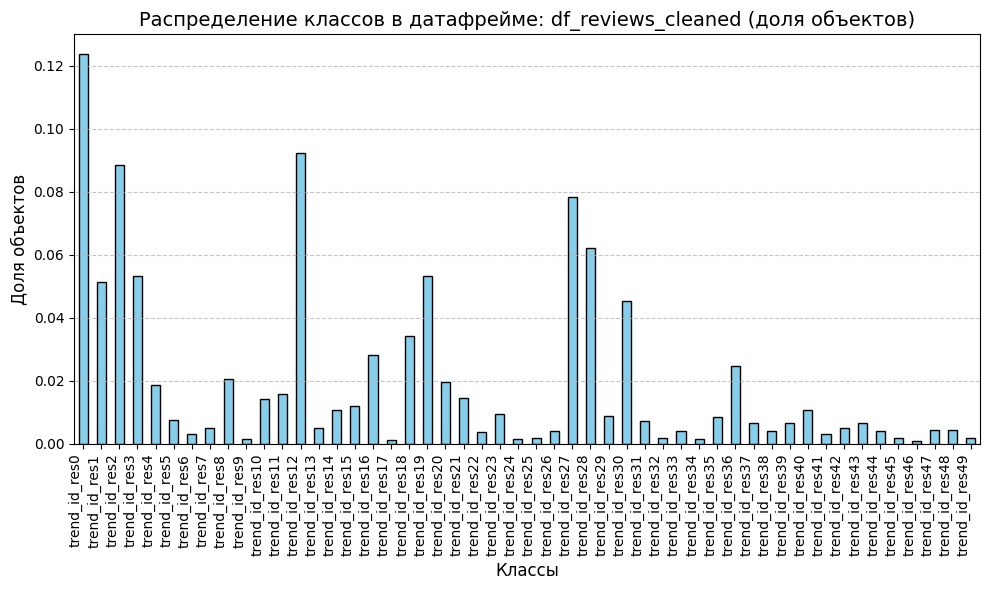

In [36]:
# Посмотрим распределение классов в датасете
analyze_class_distribution(df_reviews, "trend_id_res")

Наблюдается дисбаланс классов, для большинства классов представлено менее 2%

### Рассчёт весов классов

In [37]:
# Получаем количество примеров для каждого класса
class_counts = df_reviews.iloc[:, 4:].sum(axis=0).values

# Вычисляем веса классов
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_counts),
    y=class_counts
).tolist()

print("Веса классов:", class_weights)

Веса классов: [1.1904761904761905, 1.1904761904761905, 0.5952380952380952, 1.1904761904761905, 0.5952380952380952, 0.5952380952380952, 0.5952380952380952, 1.1904761904761905, 0.5952380952380952, 0.5952380952380952, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 0.5952380952380952, 0.5952380952380952, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905, 1.1904761904761905]


## Подготовка данных

In [38]:
df_reviews[['assessment', 'tags', 'text', 'trend_id_res18', 'trend_id_res20']].loc[[7773, 2393]]

,assessment,tags,text,trend_id_res18,trend_id_res20
7773,4.0,"{ASSORTMENT,PRODUCTS_QUALITY,PRICE,PROMOTIONS,...",Все хорошо,0,1
2393,6.0,"{PRICE,PROMOTIONS,CATALOG_NAVIGATION}",Все хорошо,1,0


В тренировочных данных встречаются отзывы с одинаковым текстом, но с разными оценками и тегами и распределенные в разные классы, объеденим в одну строку `assessment: ..., tags: ..., text: ...`

In [39]:
# Создаём датафрейм со столбцом 'formatted_text'
df_text_train = pd.DataFrame({
    'formatted_text': format_texts(df_reviews)
})

# Просмотр первых нескольких строк датафрейма
df_text_train.head()

,formatted_text
0,"assessment: 6.0, tags: {ASSORTMENT,PROMOTIONS,..."
1,"assessment: 4.0, tags: {ASSORTMENT,PRICE,PRODU..."
2,"assessment: 6.0, tags: {DELIVERY,PROMOTIONS,PR..."
3,"assessment: 6.0, tags: {PRICE,PROMOTIONS,ASSOR..."
4,"assessment: 5.0, tags: {ASSORTMENT,PRODUCTS_QU..."


In [40]:
# Создаём новый датафрейм, исключив столбцы 'index', 'assessment', 'tags', 'text'
df_labels_train = df_reviews.drop(columns=['index', 'assessment', 'tags', 'text'])

# Просмотр первых нескольких строк датафрейма
df_labels_train.head()

,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,trend_id_res9,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# Создаём датафрейм со столбцом 'formatted_text'
df_text_test = pd.DataFrame({
    'formatted_text': format_texts(df_test)
})

# Просмотр первых нескольких строк датафрейма
df_text_test.head()

,formatted_text
0,"assessment: 5.0, tags: {PROMOTIONS}, text: Кру..."
1,"assessment: 3.0, tags: {DELIVERY}, text: После..."
2,"assessment: 5.0, tags: {ASSORTMENT,PROMOTIONS}..."
3,"assessment: 2.0, tags: {PRICE,DELIVERY,ASSORTM..."
4,"assessment: 5.0, tags: {ASSORTMENT,PRODUCTS_QU..."


Создаём кастомный Dataset для тренировки модели.

In [42]:
# Форматирование данных для BERT
class ReviewsDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        item = {key: val.squeeze(0) for key, val in encoded.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

### Разделение данных на обучающую и валидационную выборки

Создадим объект для многометочной стратификации

In [43]:
mskf = MultilabelStratifiedKFold(n_splits=5,
                                 random_state=RANDOM_STATE,
                                 shuffle=True)

Разделим данные на индексы объектов для тренировочной и валидационной выборки

In [44]:
train_idx, val_idx = next(mskf.split(df_text_train,
                                     df_labels_train))

Сформируем выборки, используя индексы для создания тренировочных и валидационных выборок

In [45]:
train_texts, val_texts = df_text_train.iloc[train_idx], df_text_train.iloc[val_idx]

In [46]:
train_labels, val_labels = df_labels_train.iloc[train_idx], df_labels_train.iloc[val_idx]

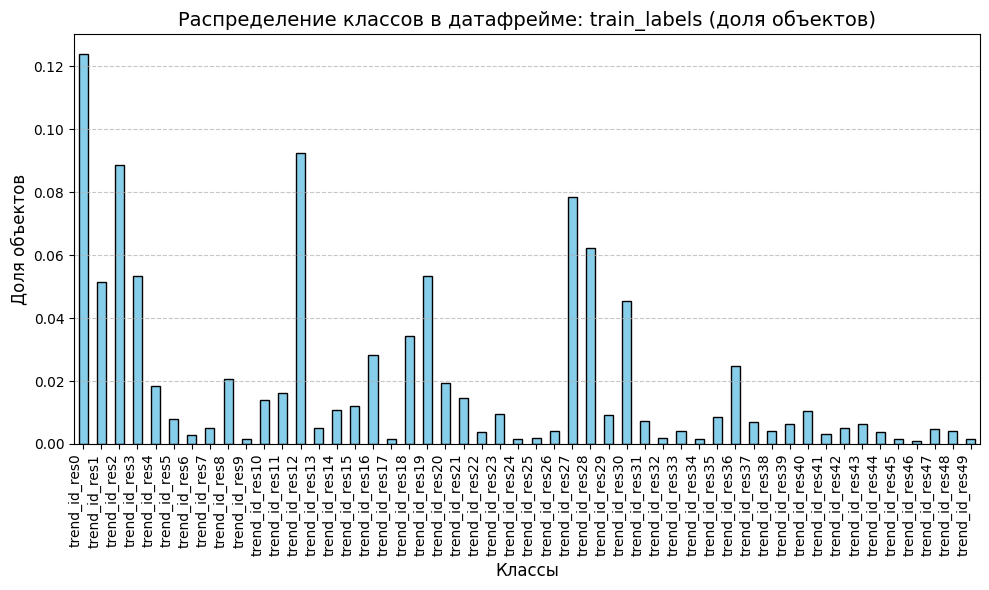

In [47]:
# Посмотрим распределение классов в тренировочной выборке
train_labels.name = 'train_labels'
analyze_class_distribution(train_labels, "trend_id_res")

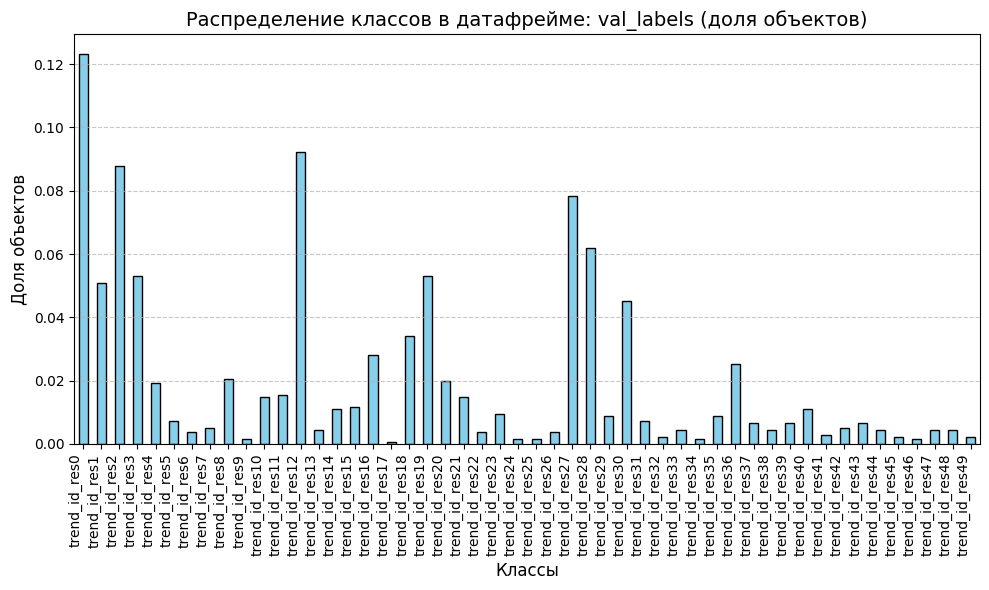

In [48]:
# Посмотрим распределение классов в валидационной выборке
val_labels.name = 'val_labels'
analyze_class_distribution(val_labels, "trend_id_res")

Распределение классов в тренировочной и валидационной выборках, соответствует распределению классов в основном датасете

### Добавление в тренировочный датасет описаний классов

In [49]:
# Создаём новый датафрейм, объединяя значения из столбцов 'trend' и 'explanation'
df_trends_text = pd.DataFrame()
df_trends_text['formatted_text'] = df_trends['trend'] + df_trends['explanation']

# Просмотр первых нескольких строк датафрейма
df_trends_text.head()

,formatted_text
0,Долгая доставка- долго везёте - очень долго ве...
1,Доставка стала долгой- клиент делает акцент на...
2,Время доставки не соответствует заявленому- кл...
3,Регулярные опоздания- клиент акцентирует внима...
4,Не отследить реальное время доставки- клиент г...


In [50]:
# Создаём one-hot кодирование для столбца 'trend_id'
df_trends['labels'] = df_trends['trend_id'].apply(
    lambda x: np.eye(50)[x].tolist()
)

In [51]:
# Создаём one-hot кодирование для столбца 'trend_id'
df_trends['labels'] = df_trends['trend_id'].apply(
    lambda x: np.eye(50)[x].tolist()
)

# Разделяем списки one-hot кодирования на отдельные столбцы
df_trends_labels = pd.DataFrame(
    df_trends['labels'].tolist(), columns=[f'trend_id_res{i}' for i in range(50)]
)

# Просмотр первых нескольких строк датафрейма
df_trends_labels.head()

,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,trend_id_res9,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# Объединяем
train_texts_c = pd.concat([df_trends_text, train_texts], ignore_index=True)

In [53]:
train_labels_c = pd.concat([df_trends_labels, train_labels], ignore_index=True)

In [54]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [55]:
train_dataset = ReviewsDataset(train_texts_c["formatted_text"].tolist(),
                               train_labels_c.values,
                               tokenizer)
val_dataset = ReviewsDataset(val_texts["formatted_text"].tolist(),
                             val_labels.values,
                             tokenizer)

## Создание и обучение модели

Загружаем предобученную модель RoBERTa.

In [57]:
# Загружаем модель с нужным количеством меток
bert_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,
                                                                num_labels=df_labels_train.shape[1]).to(DEVICE)

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/bert-base-bg-cs-pl-ru-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
# Настраиваем модель для multi-label классификации
bert_model.config.problem_type = "multi_label_classification"

In [59]:
# Устанавливаем веса классов в слои модели
bert_model.config.class_weights = class_weights

### Настройка обучения

In [60]:
name = 'bert-base-bg-cs-pl-ru-cased'


Настраиваем параметры обучения

### Создание Trainer для обучения.

In [61]:
# Задаём параметры обучения BERT
training_args = TrainingArguments(
    output_dir="./" + name,          # Директория для сохранения результатов
    num_train_epochs=15,             # Количество эпох обучения
    per_device_train_batch_size=16,  # Размер батча для тренировки
    per_device_eval_batch_size=16,   # Размер батча для валидации
    weight_decay=0.02,               # Коэффициент L2-регуляризации
    logging_dir='./logs',            # Директория для логирования
    logging_steps=10,                # Логирование каждые 10 шагов
    eval_strategy="epoch",           # Оценка на каждой эпохе
    save_strategy="epoch",           # Сохранение на каждой эпохе
    load_best_model_at_end=True,     # Загружать лучшую модель по окончании обучения
    metric_for_best_model="accuracy",# Метрика для определения лучшей модели
    seed=RANDOM_STATE,               # Установка фиксированного значения для воспроизводимости результатов
    fp16=True,                       # Использование 16-битной точности для ускорения и экономии памяти на GPU
)

In [62]:
# Добавляем callback для ранней остановки
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=10)

In [63]:
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[early_stopping_callback],
)

<ipython-input-63-00888e5252ab>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Обучение модели

In [ ]:
# Настройка Wandb
wandb.login(key=WANDB_TOKEN)

wandb: Currently logged in as: danielnru (danielnru-kemerovo-state-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
trainer.train_dataset = train_dataset
trainer.eval_dataset = val_dataset
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.066000,0.068604,0.456372,0.000000
2,0.049300,0.047891,0.561998,0.274114
3,0.036500,0.040647,0.613088,0.371869
4,0.032700,0.035282,0.650402,0.474955
5,0.031700,0.032922,0.669920,0.514049
6,0.029800,0.031454,0.693456,0.556729
7,0.019100,0.030265,0.703215,0.587728
8,0.018100,0.029793,0.714696,0.602854
9,0.016600,0.029466,0.718140,0.611228
10,0.017200,0.029200,0.722158,0.616395


TrainOutput(global_step=4390, training_loss=0.03777501018959732, metrics={'train_runtime': 2214.7102, 'train_samples_per_second': 31.679, 'train_steps_per_second': 1.982, 'total_flos': 1.846782734352384e+16, 'train_loss': 0.03777501018959732, 'epoch': 10.0})

### Оценка модели

Оценим качество модели на валидационных данных.

In [ ]:
# Оценка модели
results = trainer.evaluate(val_dataset)
print(results)

{'eval_loss': 0.02920026145875454, 'eval_accuracy': 0.722158438576349, 'eval_f1_weighted': 0.6163953524156007, 'eval_runtime': 13.7386, 'eval_samples_per_second': 126.796, 'eval_steps_per_second': 7.934, 'epoch': 10.0}


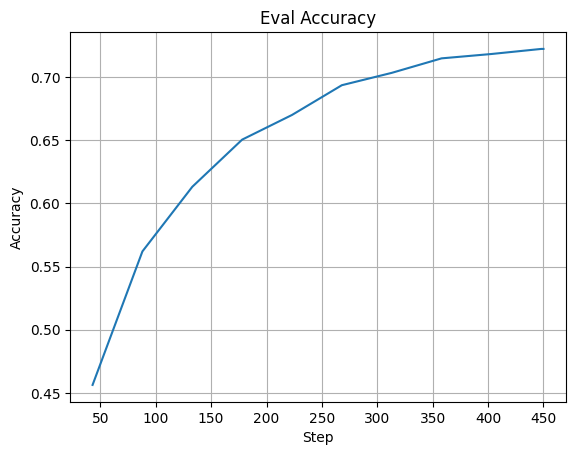

In [68]:
api = wandb.Api()
run = api.run("danielnru-kemerovo-state-university/huggingface/xiawk64t")

# Получаем данные eval/accuracy
history = run.history(keys=["eval/accuracy"])

# Отобразим график
plt.plot(history["_step"], history["eval/accuracy"])
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Eval Accuracy")
plt.grid()
plt.show()

### Сохранение модели

In [ ]:
PATH_SAVE = PATH + 'save/' + name

In [ ]:
# Путь для сохранения модели и токенизатора
model_save_path = PATH_SAVE
tokenizer_save_path = PATH_SAVE

# Сохраняем модель
bert_model.save_pretrained(model_save_path)

# Сохраняем токенизатор
tokenizer.save_pretrained(tokenizer_save_path)

print(f"Модель сохранена в {model_save_path}")
print(f"Токенайзер сохранён в {tokenizer_save_path}")

Модель сохранена в /content/drive/MyDrive/Samokat/save/bert-base-bg-cs-pl-ru-cased
Токенайзер сохранён в /content/drive/MyDrive/Samokat/save/bert-base-bg-cs-pl-ru-cased


## Вывод

### **Ход работы**  

1. **Подготовка данных:**  
   - Изучены тексты отзывов и их метки.  
   - Проведена токенизация текстов с использованием модели BERT.   

2. **Обучение модели:**  
   - Были протестированы различные BERT-модели, в результате была выбрана `bert_base_bg_cs_pl_ru_cased`.
   - Использован AdamW оптимизатор и обучение с линейным уменьшением learning rate (scheduler).  
   - Реализован ранняя остановка (Early Stopping) для предотвращения переобучения.  

| №  | Модель              | Batch Size (Train/Eval) | Warmup Steps | Weight Decay | Eval Loss          | Eval Accuracy       | Eval F1 Weighted       |
|----|---------------------|-------------------------|--------------|--------------|--------------------|---------------------|-------------------------|
| 1  | RoBERTa        | 50 / 50                | -            | 0.01         | -                  | -                   | -                       |
| 2  | RoBERTa         | 32 / 32                | -            | 0.01         | -                  | 0.412972972972973   | -                       |
| 3  | RoBERTa         | 16 / 64                | 500          | 0.01         | 0.0622814483940601 | 0.4097297297297297  | 0.5352045807404863      |
| 4  | DeBERTa        | 16 / 64                | 500          | 0.01         | 0.053661085665226  | 0.4962162162162162  | 0.6297241610458998      |
| 5  | DEBERTa        | 8 / 64                 | 500          | 0.01         | 0.0837200433015823 | 0.518918918918919   | 0.6794210524474236      |
| 6  | ALBERT Base v2  | 8 / 64                 | 500          | 0.01         | 0.0873901546001434 | 0.10054054054054054 | 0.15582162230049554     |
| 7  | DistilBERT   | 8 / 64                 | 500          | 0.01         | 0.07145585119724274| 0.46054054054054056 | 0.6196191350717499      |
| 8  | bert-base-multilingual | 8 / 64         | 500          | 0.01         | 0.0706319659948349 | 0.532972972972973   | 0.6919279418477221      |
| 9  | base-bg-cs-pl-ru-cased | 8 / 64        | 500          | 0.01         | 0.058454789221286774 | 0.5383783783783784 | 0.7042346808168742      |
| 10 | base-bg-cs-pl-ru-cased  | 4 / 64        | 500          | 0.01         | 0.06231588125228882 | 0.492972972972973   | 0.6534474904658384      |
| 11 | base-bg-cs-pl-ru-cased | 16 / 64       | 500          | 0.01         | 0.06396689265966415 | 0.5308108108108108  | 0.6873825334654116      |
| 12 | bert-base-multilingual | 16 / 64       | 500          | 0.01         | 0.05772503837943077 | 0.5308108108108108  | 0.6917886264070219      |
| 13 | base-bg-cs-pl-ru-cased + веса классов | 8 / 64     | 500          | 0.01         | 0.06049782410264015 | 0.5145945945945946  | 0.6797857023327455      |
| 14 | base-bg-cs-pl-ru-cased + веса классов  | 8 / 64      | 500          | 0.01         | 0.05954109877347946 | 0.4669603524229075  | 0.6204531972947426      |
| 15 | base-bg-cs-pl-ru-cased + веса классов | 8 / 64      | 500          | 0.02         | 0.06215649098157883 | 0.4779735682819383  | 0.6267315453298563      |
| 16 | base-bg-cs-pl-ru-cased + веса классов, размечаны пропущенные данные | 16 / 64      | 300          | 0.02         | 0.0580533929169178 | 0.5597874224977857  | 0.732149639693681      |
| 17 | base-bg-cs-pl-ru-cased + веса классов, сокращено количество объектов преобладающих классов | 16 / 64      | 300          | 0.02         | 0.057723816484212875 | 0.5006337135614702  | 0.7207890842047736      |
| 18 | base-bg-cs-pl-ru-cased + веса классов | 16 / 16      | 300          | 0.02         | 0.05449923500418663 | 0.5744870651204282  | 0.7302631210901074      |
| 19 | base-bg-cs-pl-ru-cased + веса классов | 16 / 16      | -          | 0.02         | 0.02920026145875454 | 0.722158438576349  | 0.6163953524156007      |


3. **Оценка модели:**  
   - Проведена кросс-валидация на обучающей выборке.  

---

### **Результаты**

#### **Метрика на валидационных данных**  
Accuracy: **0.723**.  

---

### **Выводы и рекомендации**  
- Использование модели BERT позволило справиться с задачей множественной классификации.  

- Для дальнейшего улучшения результатов можно:
  - Обучить модель на большем количестве эпох
  - Попробовать другие архитектуры моделей
  - Использовать ансамбль моделей  
  - Использовать аугментацию данных для увеличения обучающей выборки.  
  - Провести дополнительный анализ ошибок модели и уточнить разметку данных.  

---